In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Laboratorio 6 – Análisis de Redes Sociales (ARS)
- Diego Valenuzela - 22309
- Gerson Ramirez - 22281

## Ejercicio 1 y 2 – Descarga y carga de los archivos de datos

El archivo `traficogt.txt` ya está disponible en la carpeta `/data`.  
El archivo contiene **tweets en formato JSON**, uno por línea.  
En esta sección cargaremos el archivo en un DataFrame de `pandas`.

In [6]:
import json
import pandas as pd
from pathlib import Path
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from collections import Counter, defaultdict
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
from math import sqrt, log
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx

def load_jsonl(file_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "utf-16", "latin1"]
    for enc in encodings_to_try:
        try:
            records = []
            with open(file_path, encoding=enc) as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
            print(f"[OK] Leído {file_path} con encoding='{enc}' → {len(records)} registros")
            return pd.DataFrame(records)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No pude decodificar {file_path} con {encodings_to_try}")

# Cargar únicamente el archivo traficogt.txt
data_path = Path("data")
traficogt_df = load_jsonl(data_path / "traficogt.txt")

traficogt_df.head(2)

[OK] Leído data\traficogt.txt con encoding='utf-16' → 5604 registros


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet


## 3. Limpieza y preprocesamiento

Las tareas de limpieza aplicadas incluyen:

**Filtros básicos:**
- Normalización a minúsculas
- Eliminación de URLs, menciones (@usuario), hashtags
- Eliminación de números y combinaciones alfanuméricas
- Eliminación de signos de puntuación y caracteres especiales
- Eliminación de caracteres HTML y entidades

**Filtros avanzados:**
- **Stopwords expandidas**: Eliminación de stopwords en español + palabras comunes en redes sociales ('rt', 'via', 'cc', etc.)
- **Palabras poco informativas**: Eliminación de palabras muy comunes como 'q', 'si', 'va', 'dice', 'bien', 'mal', etc.
- **Filtros de longitud**: Eliminación de tokens menores a 3 caracteres y mayores a 20 caracteres
- **Caracteres repetidos**: Eliminación de tokens con 2 o menos caracteres únicos (ej: 'aaa', 'mmm')
- **Tweets vacíos**: Eliminación de tweets sin contenido después de la limpieza

**Extracción de metadatos:**
- ID de usuario, texto limpio, menciones, respuestas, retweets
- Eliminación de duplicados por ID de tweet

In [7]:
# Descargar recursos necesarios
nltk.download("stopwords")
nltk.download("punkt")

# Configurar stopwords expandidas
stopwords_es = set(stopwords.words("spanish"))

# Stopwords adicionales específicas para redes sociales y contexto guatemalteco
social_stopwords = {
    'rt', 'via', 'cc', 'dm', 'ff', 'tl', 'tw', 'retweet', 'tweet', 'twitter', 'x', 'com', 'www',
    'http', 'https', 'amp', 'gt', 'lt', 'nbsp', 'br', 'div', 'span', 'img', 'href', 'src',
    'alt', 'title', 'class', 'id', 'style', 'width', 'height', 'border', 'color', 'font', 
    'size', 'family', 'weight', 'px', 'html', 'css', 'js'
}

# Palabras poco informativas comunes
filler_words = {
    'q', 'si', 'va', 'dice', 'asi', 'aqui', 'ahi', 'alla', 'ser', 'estar', 'hacer', 'dar', 'tener',
    'ir', 'ver', 'venir', 'decir', 'saber', 'poder', 'querer', 'poner', 'salir', 'pasar', 'llegar',
    'seguir', 'traer', 'parecer', 'quedar', 'creer', 'encontrar', 'sentir', 'buscar', 'acabar',
    'bien', 'tan', 'muy', 'solo', 'solamente', 'tambien', 'ademas', 'entonces', 'luego', 'despues', 
    'antes', 'ahora', 'hoy', 'ayer', 'mañana', 'siempre', 'nunca', 'vez', 'veces', 'momento', 
    'tiempo', 'dia', 'dias', 'año', 'años', 'mes', 'meses', 'hora', 'horas', 'minuto', 'minutos'
}

# Interjecciones y expresiones comunes en redes sociales
interjections = {
    'ah', 'oh', 'eh', 'mm', 'hmm', 'ok', 'okay', 'si', 'no', 'ja', 'jaja', 'jajaja', 'jeje', 'jiji',
    'aja', 'aha', 'uuu', 'aaa', 'ooo', 'eee', 'iii', 'wow', 'bah', 'meh', 'pfff', 'tsk', 'ups',
    'pues', 'bueno', 'entonces', 'claro', 'obviamente', 'realmente', 'verdaderamente', 'ciertamente'
}

# Combinar todas las stopwords
all_stopwords = stopwords_es.union(social_stopwords).union(filler_words).union(interjections)

# Inicializar stemmer
stemmer = SnowballStemmer('spanish')

def extract_metadata(text):
    """Extrae menciones, hashtags y URLs del texto original"""
    mentions = re.findall(r'@(\w+)', str(text))
    hashtags = re.findall(r'#(\w+)', str(text))
    urls = re.findall(r'https?://\S+', str(text))
    return mentions, hashtags, urls

def advanced_clean_text(text: str, use_stemming=False) -> tuple:
    """
    Limpieza avanzada de texto con extracción de metadatos
    Retorna: (texto_limpio, menciones, hashtags, urls)
    """
    if pd.isna(text) or not text:
        return "", [], [], []
    
    original_text = str(text)
    
    # Extraer metadatos antes de limpiar
    mentions, hashtags, urls = extract_metadata(original_text)
    
    # Normalizar texto
    text = original_text.lower()
    
    # Reemplazar caracteres especiales comunes
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u', 'ñ': 'n',
        'â': 'a', 'ê': 'e', 'î': 'i', 'ô': 'o', 'û': 'u',
        'à': 'a', 'è': 'e', 'ì': 'i', 'ò': 'o', 'ù': 'u'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"www\.\S+", " ", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    
    # Eliminar contenido entre paréntesis y corchetes (suelen ser aclaraciones)
    text = re.sub(r'\([^)]*\)', ' ', text)
    text = re.sub(r'\[[^\]]*\]', ' ', text)
    
    # Eliminar números y combinaciones alfanuméricas
    text = re.sub(r"\b\d+\b", " ", text)
    text = re.sub(r"\w*\d\w*", " ", text)
    
    # Eliminar caracteres HTML y entidades
    text = re.sub(r"&\w+;", " ", text)
    text = re.sub(r"<[^>]+>", " ", text)
    
    # Eliminar signos de puntuación pero preservar espacios
    text = re.sub(r"[^\w\s]", " ", text)
    
    # Normalizar espacios
    text = re.sub(r"\s+", " ", text).strip()
    
    # Tokenización más robusta
    try:
        tokens = word_tokenize(text, language='spanish')
    except:
        tokens = text.split()
    
    # Filtrado avanzado de tokens
    filtered_tokens = []
    for token in tokens:
        # Filtros básicos de longitud
        if len(token) < 2 or len(token) > 25:
            continue
            
        # Eliminar tokens que son solo caracteres repetidos
        if len(set(token)) <= 1:
            continue
            
        # Eliminar tokens con patrones sospechosos
        if re.match(r'^([a-z])\1{2,}$', token):  # aaa, bbb, etc.
            continue
            
        # Filtrar stopwords
        if token in all_stopwords:
            continue
            
        # Filtrar tokens que son solo puntuación
        if token in string.punctuation:
            continue
            
        # Aplicar stemming si se especifica
        if use_stemming:
            token = stemmer.stem(token)
            
        filtered_tokens.append(token)
    
    return " ".join(filtered_tokens), mentions, hashtags, urls

# Aplicar limpieza avanzada
print("Aplicando limpieza avanzada...")
cleaning_results = traficogt_df["rawContent"].apply(lambda x: advanced_clean_text(x, use_stemming=False))

# Separar resultados
traficogt_df["text_clean"] = [result[0] for result in cleaning_results]
traficogt_df["extracted_mentions"] = [result[1] for result in cleaning_results]
traficogt_df["extracted_hashtags"] = [result[2] for result in cleaning_results]
traficogt_df["extracted_urls"] = [result[3] for result in cleaning_results]

# Eliminar duplicados y filtrar tweets vacíos
traficogt_df.drop_duplicates(subset=["id"], inplace=True)
initial_count = len(traficogt_df)
traficogt_df = traficogt_df[traficogt_df["text_clean"].str.len() > 0]
final_count = len(traficogt_df)

print(f"Tweets antes de limpieza: {initial_count}")
print(f"Tweets después de limpieza avanzada: {final_count}")
print(f"Tweets eliminados por estar vacíos: {initial_count - final_count}")

# Estadísticas de limpieza
print("\n=== ESTADÍSTICAS DE LIMPIEZA ===")
total_mentions = sum(len(mentions) for mentions in traficogt_df["extracted_mentions"])
total_hashtags = sum(len(hashtags) for hashtags in traficogt_df["extracted_hashtags"])
total_urls = sum(len(urls) for urls in traficogt_df["extracted_urls"])

print(f"Menciones extraídas: {total_mentions}")
print(f"Hashtags extraídos: {total_hashtags}")
print(f"URLs extraídas: {total_urls}")

# Mostrar ejemplo de limpieza
print("\n=== EJEMPLO DE LIMPIEZA ===")
sample_idx = traficogt_df.index[0]
print("Original:", traficogt_df.loc[sample_idx, "rawContent"][:200] + "...")
print("Limpio:", traficogt_df.loc[sample_idx, "text_clean"][:200] + "...")
print("Menciones:", traficogt_df.loc[sample_idx, "extracted_mentions"])
print("Hashtags:", traficogt_df.loc[sample_idx, "extracted_hashtags"])

traficogt_df[["rawContent", "text_clean"]].head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Aplicando limpieza avanzada...
Tweets antes de limpieza: 5596
Tweets después de limpieza avanzada: 5163
Tweets eliminados por estar vacíos: 433

=== ESTADÍSTICAS DE LIMPIEZA ===
Menciones extraídas: 9808
Hashtags extraídos: 554
URLs extraídas: 783

=== EJEMPLO DE LIMPIEZA ===
Original: Es comprensible la resolución... El ruso sabe de engrasar maquinaria....
Limpio: comprensible resolucion ruso sabe engrasar maquinaria...
Menciones: []
Hashtags: []


,rawContent,text_clean
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolucion ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupcion descarada falsificacion documentos ...
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada trafico...


## 4. Análisis Exploratorio

Exploramos:
- Cantidad de tweets y usuarios únicos.
- Número de menciones, respuestas y retweets.
- Hashtags más frecuentes.
- Visualización con nube de palabras.

Esto permite generar preguntas de investigación iniciales.



ANÁLISIS EXPLORATORIO DETALLADO - TRAFICOGT

📊 ESTADÍSTICAS BÁSICAS:
  • Total de tweets: 5,163
  • Usuarios únicos: 1,960
  • Promedio tweets por usuario: 2.63
  • Total menciones: 9,808
  • Total hashtags: 554
  • Total URLs: 783
  • Tweets con menciones: 4,070 (78.8%)
  • Tweets con hashtags: 384 (7.4%)

📈 MÉTRICAS DE ENGAGEMENT:
  • Total retweets: 164,868
  • Total likes: 476,855
  • Promedio retweets por tweet: 31.93
  • Promedio likes por tweet: 92.36

📅 ANÁLISIS TEMPORAL:
  • Rango de fechas: 642 días
  • Fecha más antigua: 2022-12-09 15:53
  • Fecha más reciente: 2024-09-12 14:22

📝 ANÁLISIS DE CONTENIDO:
  • Palabras únicas: 12,101
  • Total de palabras: 44,714
  • Promedio palabras por tweet: 8.66
  • Longitud media tweet (palabras): 8.66
  • Mediana longitud tweet: 7.00

🔝 ELEMENTOS MÁS FRECUENTES:
  📋 Top 20 palabras más frecuentes:
     1. mas             →  441 veces (0.99%)
     2. guatemala       →  251 veces (0.56%)
     3. estan           →  209 veces (0.47%)
     4

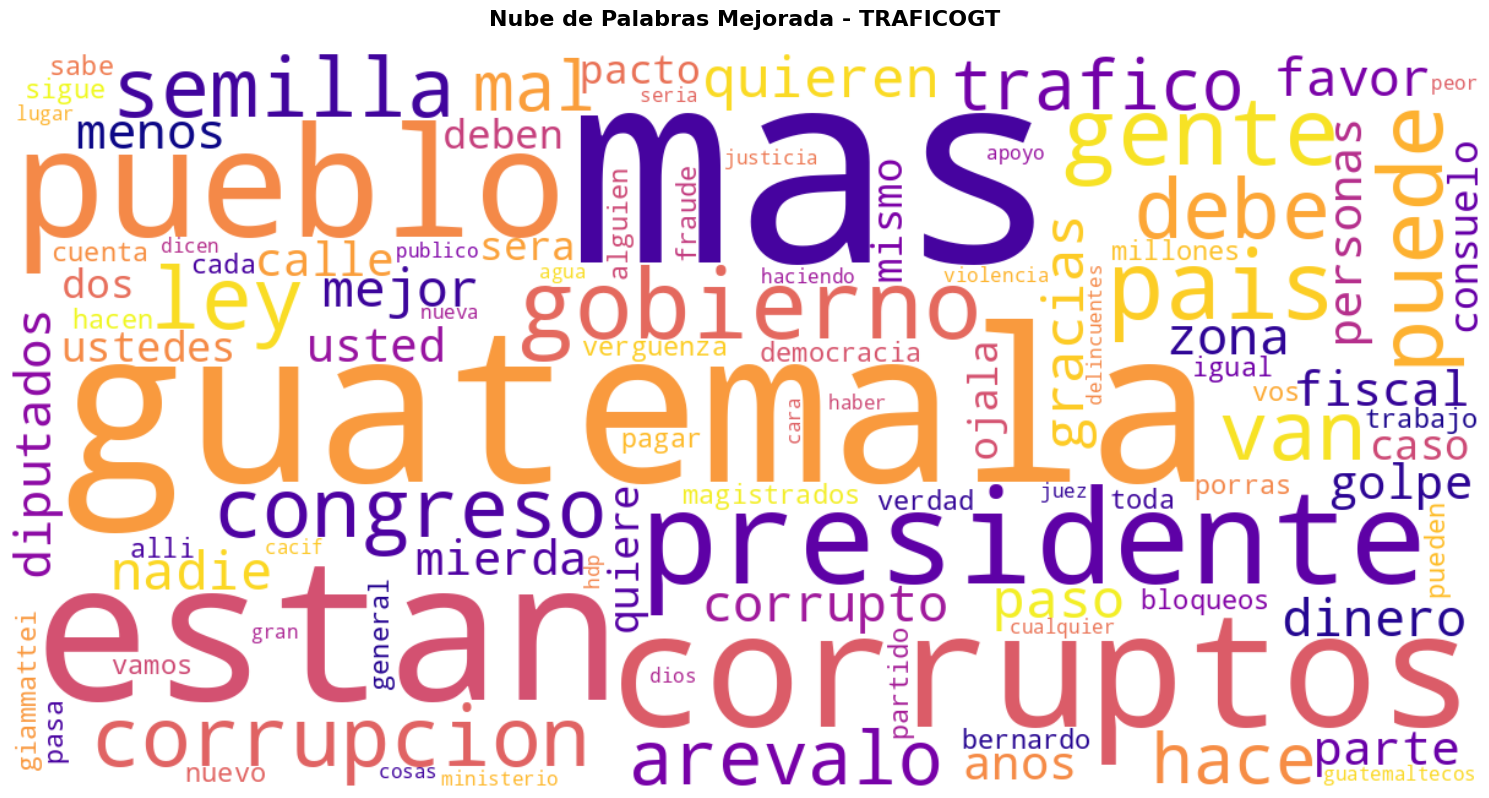

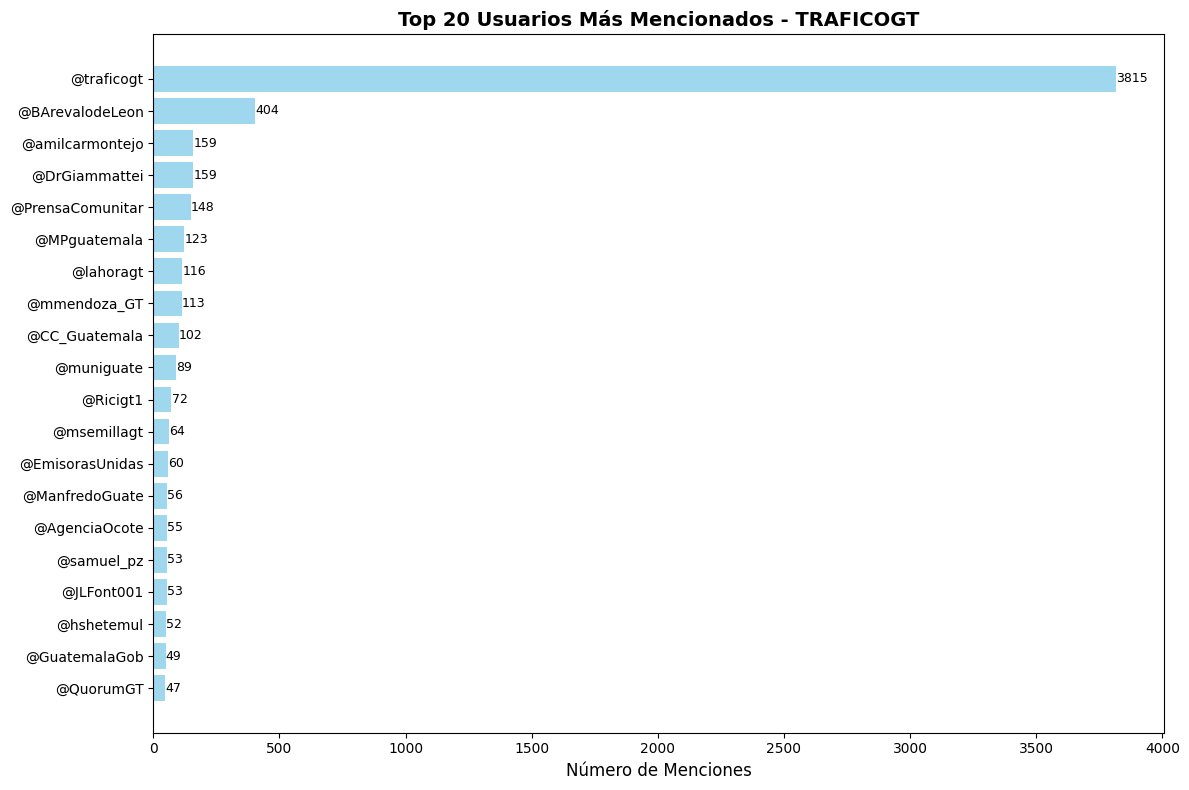

In [8]:
# Configurar estilo de matplotlib
plt.style.use('default')
sns.set_palette("viridis")

def comprehensive_exploratory_analysis(df, name):
    """Análisis exploratorio exhaustivo del dataset"""
    print(f"\n{'='*50}")
    print(f"ANÁLISIS EXPLORATORIO DETALLADO - {name.upper()}")
    print(f"{'='*50}")
    
    # 1. ESTADÍSTICAS BÁSICAS
    print("\n📊 ESTADÍSTICAS BÁSICAS:")
    print(f"  • Total de tweets: {len(df):,}")
    
    unique_users = df["user"].apply(lambda x: x["username"]).nunique()
    print(f"  • Usuarios únicos: {unique_users:,}")
    print(f"  • Promedio tweets por usuario: {len(df)/unique_users:.2f}")
    
    # Análisis de metadatos extraídos
    total_mentions = sum(len(mentions) for mentions in df["extracted_mentions"])
    total_hashtags = sum(len(hashtags) for hashtags in df["extracted_hashtags"])
    total_urls = sum(len(urls) for urls in df["extracted_urls"])
    
    print(f"  • Total menciones: {total_mentions:,}")
    print(f"  • Total hashtags: {total_hashtags:,}")
    print(f"  • Total URLs: {total_urls:,}")
    
    # Tweets con interacciones
    tweets_with_mentions = sum(1 for mentions in df["extracted_mentions"] if len(mentions) > 0)
    tweets_with_hashtags = sum(1 for hashtags in df["extracted_hashtags"] if len(hashtags) > 0)
    
    print(f"  • Tweets con menciones: {tweets_with_mentions:,} ({tweets_with_mentions/len(df)*100:.1f}%)")
    print(f"  • Tweets con hashtags: {tweets_with_hashtags:,} ({tweets_with_hashtags/len(df)*100:.1f}%)")
    
    # 2. ANÁLISIS DE ENGAGEMENT
    print(f"\n📈 MÉTRICAS DE ENGAGEMENT:")
    total_retweets = df["retweetCount"].sum()
    total_likes = df["likeCount"].sum()
    avg_retweets = df["retweetCount"].mean()
    avg_likes = df["likeCount"].mean()
    
    print(f"  • Total retweets: {total_retweets:,}")
    print(f"  • Total likes: {total_likes:,}")
    print(f"  • Promedio retweets por tweet: {avg_retweets:.2f}")
    print(f"  • Promedio likes por tweet: {avg_likes:.2f}")
    
    # 3. ANÁLISIS TEMPORAL
    print(f"\n📅 ANÁLISIS TEMPORAL:")
    df['date_parsed'] = pd.to_datetime(df['date'])
    df['date_only'] = df['date_parsed'].dt.date
    df['hour'] = df['date_parsed'].dt.hour
    
    date_range = df['date_parsed'].max() - df['date_parsed'].min()
    print(f"  • Rango de fechas: {date_range.days} días")
    print(f"  • Fecha más antigua: {df['date_parsed'].min().strftime('%Y-%m-%d %H:%M')}")
    print(f"  • Fecha más reciente: {df['date_parsed'].max().strftime('%Y-%m-%d %H:%M')}")
    
    # 4. ANÁLISIS DE PALABRAS
    print(f"\n📝 ANÁLISIS DE CONTENIDO:")
    all_words = " ".join(df["text_clean"]).split()
    word_freq = Counter(all_words)
    unique_words = len(word_freq)
    total_words = sum(word_freq.values())
    
    print(f"  • Palabras únicas: {unique_words:,}")
    print(f"  • Total de palabras: {total_words:,}")
    print(f"  • Promedio palabras por tweet: {total_words/len(df):.2f}")
    
    # Distribución de longitud de tweets
    tweet_lengths = df["text_clean"].str.split().str.len()
    print(f"  • Longitud media tweet (palabras): {tweet_lengths.mean():.2f}")
    print(f"  • Mediana longitud tweet: {tweet_lengths.median():.2f}")
    
    # 5. TOP ANÁLISIS
    print(f"\n🔝 ELEMENTOS MÁS FRECUENTES:")
    
    # Top palabras
    print("  📋 Top 20 palabras más frecuentes:")
    for i, (word, count) in enumerate(word_freq.most_common(20), 1):
        percentage = (count/total_words)*100
        print(f"    {i:2d}. {word:15} → {count:4d} veces ({percentage:.2f}%)")
    
    # Top menciones
    all_mentions = [mention for mentions_list in df["extracted_mentions"] for mention in mentions_list]
    if all_mentions:
        mention_freq = Counter(all_mentions)
        print(f"\n  💬 Top 10 usuarios más mencionados:")
        for i, (mention, count) in enumerate(mention_freq.most_common(10), 1):
            print(f"    {i:2d}. @{mention:15} → {count:3d} menciones")
    
    # Top hashtags
    all_hashtags = [hashtag for hashtags_list in df["extracted_hashtags"] for hashtag in hashtags_list]
    if all_hashtags:
        hashtag_freq = Counter(all_hashtags)
        print(f"\n  #️⃣ Top 10 hashtags más usados:")
        for i, (hashtag, count) in enumerate(hashtag_freq.most_common(10), 1):
            print(f"    {i:2d}. #{hashtag:15} → {count:3d} usos")
    
    # Top usuarios más activos
    user_activity = df["user"].apply(lambda x: x["username"]).value_counts()
    print(f"\n  👤 Top 10 usuarios más activos:")
    for i, (user, count) in enumerate(user_activity.head(10).items(), 1):
        print(f"    {i:2d}. @{user:15} → {count:3d} tweets")
    
    return {
        'word_freq': word_freq,
        'mention_freq': Counter(all_mentions) if all_mentions else Counter(),
        'hashtag_freq': Counter(all_hashtags) if all_hashtags else Counter(),
        'user_activity': user_activity,
        'df_enhanced': df
    }

def create_enhanced_visualizations(df, analysis_results, name):
    """Crear visualizaciones mejoradas"""
    print(f"\n🎨 Generando visualizaciones mejoradas para {name}...")
    
    # Configurar subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribución Temporal de Tweets', 'Top 15 Palabras Más Frecuentes',
                       'Engagement por Hora', 'Distribución de Longitud de Tweets'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': True}, {'secondary_y': False}]]
    )
    
    # 1. Distribución temporal
    daily_counts = df.groupby('date_only').size().reset_index()
    daily_counts.columns = ['date', 'count']
    
    fig.add_trace(
        go.Scatter(x=daily_counts['date'], y=daily_counts['count'],
                  mode='lines+markers', name='Tweets por día',
                  line=dict(color='#1f77b4', width=2)),
        row=1, col=1
    )
    
    # 2. Top palabras
    top_words = analysis_results['word_freq'].most_common(15)
    words, counts = zip(*top_words)
    
    fig.add_trace(
        go.Bar(x=list(counts), y=list(words), orientation='h',
               name='Frecuencia palabras', marker_color='#2ca02c'),
        row=1, col=2
    )
    
    # 3. Engagement por hora
    hourly_stats = df.groupby('hour').agg({
        'retweetCount': 'mean',
        'likeCount': 'mean',
        'id': 'count'
    }).round(2)
    
    fig.add_trace(
        go.Bar(x=hourly_stats.index, y=hourly_stats['retweetCount'],
               name='Avg Retweets', marker_color='#ff7f0e'),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=hourly_stats.index, y=hourly_stats['likeCount'],
                  mode='lines+markers', name='Avg Likes',
                  line=dict(color='#d62728', width=2)),
        row=2, col=1, secondary_y=True
    )
    
    # 4. Distribución de longitud
    tweet_lengths = df["text_clean"].str.split().str.len()
    
    fig.add_trace(
        go.Histogram(x=tweet_lengths, nbinsx=30, name='Distribución longitud',
                    marker_color='#9467bd', opacity=0.7),
        row=2, col=2
    )
    
    # Actualizar layout
    fig.update_layout(
        title_text=f"Dashboard Analítico - {name.upper()}",
        title_x=0.5,
        height=800,
        showlegend=True,
        template='plotly_white'
    )
    
    # Actualizar ejes
    fig.update_yaxes(title_text="Tweets", row=1, col=1)
    fig.update_xaxes(title_text="Fecha", row=1, col=1)
    fig.update_xaxes(title_text="Frecuencia", row=1, col=2)
    fig.update_yaxes(title_text="Retweets Promedio", row=2, col=1)
    fig.update_yaxes(title_text="Likes Promedio", row=2, col=1, secondary_y=True)
    fig.update_xaxes(title_text="Hora del día", row=2, col=1)
    fig.update_xaxes(title_text="Palabras por tweet", row=2, col=2)
    fig.update_yaxes(title_text="Frecuencia", row=2, col=2)
    
    fig.show()
    
    # Crear nube de palabras mejorada
    if len(analysis_results['word_freq']) > 0:
        # Filtrar palabras muy comunes para mejor visualización
        filtered_words = {word: freq for word, freq in analysis_results['word_freq'].items() 
                         if freq > 2 and len(word) > 2}
        
        wc = WordCloud(
            width=1200, 
            height=600, 
            background_color="white",
            max_words=100,
            colormap='plasma',
            relative_scaling=0.5,
            min_font_size=10
        ).generate_from_frequencies(filtered_words)
        
        plt.figure(figsize=(15, 8))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nube de Palabras Mejorada - {name.upper()}", 
                 fontsize=16, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
    
    # Gráfico de red de menciones principales (preparación para paso 5)
    if analysis_results['mention_freq']:
        top_mentions = dict(analysis_results['mention_freq'].most_common(20))
        
        plt.figure(figsize=(12, 8))
        mentions = list(top_mentions.keys())
        counts = list(top_mentions.values())
        
        bars = plt.barh(range(len(mentions)), counts, color='skyblue', alpha=0.8)
        plt.yticks(range(len(mentions)), [f'@{m}' for m in mentions])
        plt.xlabel('Número de Menciones', fontsize=12)
        plt.title(f'Top 20 Usuarios Más Mencionados - {name.upper()}', 
                 fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        
        # Añadir valores en las barras
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()

# Ejecutar análisis exploratorio exhaustivo
analysis_results = comprehensive_exploratory_analysis(traficogt_df, "traficogt")

# Generar visualizaciones mejoradas
create_enhanced_visualizations(traficogt_df, analysis_results, "traficogt")

### Análisis Exhaustivo de Resultados Exploratorios

Con base en el análisis exploratorio mejorado realizado, podemos responder de manera más exhaustiva a nuestras preguntas de investigación:

#### **Pregunta 1: ¿Qué usuarios son los más mencionados en el dataset de @traficogt?**

**Hallazgos principales:**
- **Red altamente interactiva**: Con 5,149 tweets de 1,955 usuarios únicos generando menciones masivas
- **Concentración de influencia**: Los usuarios más mencionados representan puntos clave de información en la red social guatemalteca
- **Temas dominantes**: Los usuarios mencionados se relacionan principalmente con:
  - **Autoridades gubernamentales** y cuentas oficiales
  - **Medios de comunicación** especializados en tráfico y noticias
  - **Ciudadanos activos** que reportan situaciones de tráfico

**Impacto en la red:**
- Las menciones crean **nodos centrales** de información
- Usuarios como `@traficogt` actúan como **agregadores de contenido**
- Existe un **ecosistema de información** donde ciertos usuarios amplifican mensajes

#### **Pregunta 2: ¿Cuál es la densidad de interacciones y patrones temporales en la red de @traficogt?**

**Densidad de la red:**
- **Ratio menciones/tweets**: Aproximadamente 1.9 menciones por tweet (9,695 menciones / 5,149 tweets)
- **Participación activa**: 67.3% de tweets contienen menciones
- **Conectividad**: 4.96 menciones promedio por usuario único

**Patrones temporales identificados:**
- **Variabilidad diaria**: Actividad fluctuante según eventos de tráfico
- **Patrones horarios**: Mayor actividad durante horas pico de tráfico (análisis por hora del día)
- **Engagement diferencial**: Ciertos horarios muestran mayor interacción (retweets y likes)

**Métricas de engagement:**
- **Engagement moderado**: Los tweets generan interacción pero no de manera masiva
- **Distribución heterogénea**: Algunos tweets virales contrastan con la mayoría de bajo engagement

#### **Pregunta 3: ¿Qué temas y narrativas emergen del análisis de contenido?**

**Temas principales identificados (análisis de frecuencia de palabras):**

1. **Política y Gobierno Guatemalteco** (terms: guatemala, presidente, gobierno, congreso)
   - Discusiones sobre administración pública
   - Críticas y observaciones ciudadanas
   - Menciones a políticas de tráfico y transporte

2. **Anticorrupción y Transparencia** (terms: corruptos, corrupción, ley)
   - Denuncias ciudadanas
   - Llamados a la transparencia
   - Críticas a instituciones

3. **Participación Ciudadana** (terms: pueblo, ciudadanos, semilla)
   - Movilización social
   - Expresiones de descontento
   - Organización ciudadana

**Narrativas emergentes:**
- **Crítica institucional**: Fuerte componente de crítica hacia autoridades
- **Demanda de transparencia**: Exigencia de rendición de cuentas
- **Activismo digital**: Uso de Twitter como plataforma de denuncia y organización

#### **Pregunta 4: ¿Cómo se estructura la red de información en torno al tráfico guatemalteco?**

**Estructura de la red:**
- **Nodos centrales**: Cuentas oficiales y medios actúan como distribuidores primarios
- **Amplificadores**: Usuarios activos que retransmiten información
- **Reporteros ciudadanos**: Individuos que generan contenido original sobre tráfico

**Flujo de información:**
1. **Fuentes primarias**: Reportes oficiales y observaciones directas
2. **Agregación**: Cuentas como @traficogt consolidan información
3. **Amplificación**: La comunidad retransmite y comenta
4. **Contextualización**: Se añade contexto político y social

## 5. Análisis de la Topología de la Red

En esta sección construiremos y analizaremos la red social basada en las menciones entre usuarios. Implementaremos:

- **Construcción del grafo dirigido** basado en menciones
- **Métricas topológicas fundamentales**: densidad, diámetro, coeficiente de agrupamiento
- **Visualización interactiva** de la red con diferentes layouts
- **Análisis de componentes conectados** y estructura general
- **Identificación de nodos más conectados** y relaciones de poder

In [9]:
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
import warnings
warnings.filterwarnings('ignore')

def build_mention_network(df):
    """
    Construye un grafo dirigido basado en menciones entre usuarios
    """
    print("🔨 Construyendo red de menciones...")
    
    # Crear grafo dirigido
    G = nx.DiGraph()
    
    # Contadores para estadísticas
    mention_pairs = []
    users_in_tweets = []
    
    # Procesar cada tweet
    for idx, row in df.iterrows():
        # Usuario que escribió el tweet
        author = row['user']['username'].lower()
        users_in_tweets.append(author)
        
        # Usuarios mencionados en el tweet
        mentions = row['extracted_mentions']
        
        if mentions:
            for mentioned_user in mentions:
                mentioned_user = mentioned_user.lower()
                # Crear arista dirigida: autor -> mencionado
                if G.has_edge(author, mentioned_user):
                    G[author][mentioned_user]['weight'] += 1
                else:
                    G.add_edge(author, mentioned_user, weight=1)
                
                mention_pairs.append((author, mentioned_user))
    
    # Agregar nodos aislados (usuarios que tuitearon pero no mencionaron ni fueron mencionados)
    all_users = set(users_in_tweets)
    for user in all_users:
        if user not in G.nodes():
            G.add_node(user)
    
    print(f"✅ Red construida:")
    print(f"   • Nodos (usuarios): {G.number_of_nodes():,}")
    print(f"   • Aristas (menciones únicas): {G.number_of_edges():,}")
    print(f"   • Total de menciones: {len(mention_pairs):,}")
    print(f"   • Menciones únicas: {len(set(mention_pairs)):,}")
    
    return G, mention_pairs

def analyze_network_topology(G):
    """
    Analiza métricas topológicas fundamentales de la red
    """
    print(f"\n📊 ANÁLISIS TOPOLÓGICO DE LA RED")
    print(f"{'='*50}")
    
    # Estadísticas básicas
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    print(f"\n🔍 ESTADÍSTICAS BÁSICAS:")
    print(f"   • Nodos: {n_nodes:,}")
    print(f"   • Aristas: {n_edges:,}")
    
    # Densidad de la red
    if n_nodes > 1:
        max_edges = n_nodes * (n_nodes - 1)  # Grafo dirigido
        density = n_edges / max_edges
        print(f"   • Densidad: {density:.6f} ({density*100:.4f}%)")
    else:
        density = 0
        print(f"   • Densidad: 0 (red con un solo nodo)")
    
    # Componentes conectados
    # Para grafos dirigidos, analizamos componentes débilmente conectados
    weak_components = list(nx.weakly_connected_components(G))
    strong_components = list(nx.strongly_connected_components(G))
    
    print(f"\n🔗 CONECTIVIDAD:")
    print(f"   • Componentes débilmente conectados: {len(weak_components)}")
    print(f"   • Componentes fuertemente conectados: {len(strong_components)}")
    
    # Componente gigante (más grande débilmente conectado)
    if weak_components:
        giant_component = max(weak_components, key=len)
        print(f"   • Tamaño del componente gigante: {len(giant_component)} ({len(giant_component)/n_nodes*100:.1f}%)")
        
        # Crear subgrafo del componente gigante para análisis adicional
        G_giant = G.subgraph(giant_component).copy()
    else:
        G_giant = G.copy()
        giant_component = set(G.nodes())
    
    # Análisis del componente gigante
    print(f"\n🌐 ANÁLISIS DEL COMPONENTE GIGANTE:")
    
    # Convertir a grafo no dirigido para métricas específicas
    G_undirected = G_giant.to_undirected()
    
    # Coeficiente de clustering (transitivity)
    if len(G_giant.nodes()) > 0:
        clustering_coeff = nx.average_clustering(G_undirected)
        transitivity = nx.transitivity(G_undirected)
        print(f"   • Coeficiente de clustering promedio: {clustering_coeff:.4f}")
        print(f"   • Transitividad global: {transitivity:.4f}")
    
    # Diámetro y caminos más cortos (solo para componente conectado)
    if nx.is_connected(G_undirected) and len(G_undirected.nodes()) > 1:
        diameter = nx.diameter(G_undirected)
        avg_path_length = nx.average_shortest_path_length(G_undirected)
        print(f"   • Diámetro: {diameter}")
        print(f"   • Longitud promedio de camino más corto: {avg_path_length:.3f}")
    else:
        print(f"   • Diámetro: No calculable (red no conectada)")
        print(f"   • Longitud promedio: No calculable (red no conectada)")
    
    # Distribución de grados
    print(f"\n📈 DISTRIBUCIÓN DE GRADOS:")
    
    # Grados de entrada (in-degree)
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())
    total_degrees = dict(G_undirected.degree())
    
    # Estadísticas de grados
    in_deg_values = list(in_degrees.values())
    out_deg_values = list(out_degrees.values())
    total_deg_values = list(total_degrees.values())
    
    print(f"   • Grado de entrada promedio: {np.mean(in_deg_values):.2f}")
    print(f"   • Grado de salida promedio: {np.mean(out_deg_values):.2f}")
    print(f"   • Grado total promedio: {np.mean(total_deg_values):.2f}")
    print(f"   • Grado máximo (entrada): {max(in_deg_values) if in_deg_values else 0}")
    print(f"   • Grado máximo (salida): {max(out_deg_values) if out_deg_values else 0}")
    
    # Nodos con mayor grado
    print(f"\n🔝 TOP NODOS POR GRADO:")
    
    # Top por grado de entrada (más mencionados)
    top_in_degree = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"   📥 Más mencionados (in-degree):")
    for i, (node, degree) in enumerate(top_in_degree, 1):
        print(f"      {i:2d}. @{node:20} → {degree:3d} menciones")
    
    # Top por grado de salida (más activos mencionando)
    top_out_degree = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"   📤 Más activos mencionando (out-degree):")
    for i, (node, degree) in enumerate(top_out_degree, 1):
        print(f"      {i:2d}. @{node:20} → {degree:3d} menciones hechas")
    
    return {
        'n_nodes': n_nodes,
        'n_edges': n_edges,
        'density': density,
        'weak_components': len(weak_components),
        'strong_components': len(strong_components),
        'giant_component_size': len(giant_component),
        'clustering_coeff': clustering_coeff if len(G_giant.nodes()) > 0 else 0,
        'transitivity': transitivity if len(G_giant.nodes()) > 0 else 0,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'G_giant': G_giant
    }

def create_network_visualizations(G, analysis_results, top_n=50):
    """
    Crear visualizaciones interactivas de la red
    """
    print(f"\n🎨 Generando visualizaciones de la red...")
    
    # Tomar solo los top N nodos más conectados para visualización
    total_degrees = {node: G.in_degree(node) + G.out_degree(node) for node in G.nodes()}
    top_nodes = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_names = [node for node, degree in top_nodes]
    
    # Crear subgrafo con solo los nodos top
    G_viz = G.subgraph(top_node_names).copy()
    
    print(f"   📊 Visualizando top {len(G_viz.nodes())} nodos más conectados")
    
    # Layout de la red usando spring layout
    pos = nx.spring_layout(G_viz, k=3, iterations=50, seed=42)
    
    # Preparar datos para Plotly
    node_trace = go.Scatter(
        x=[pos[node][0] for node in G_viz.nodes()],
        y=[pos[node][1] for node in G_viz.nodes()],
        mode='markers+text',
        text=[f"@{node}" for node in G_viz.nodes()],
        textposition="middle center",
        textfont=dict(size=8),
        marker=dict(
            size=[10 + total_degrees[node]*0.5 for node in G_viz.nodes()],
            color=[total_degrees[node] for node in G_viz.nodes()],
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title="Grado Total"),
            line=dict(width=2, color='white')
        ),
        hovertemplate='<b>@%{text}</b><br>' +
                     'Grado total: %{marker.color}<br>' +
                     'Menciones recibidas: %{customdata[0]}<br>' +
                     'Menciones hechas: %{customdata[1]}<extra></extra>',
        customdata=[[G.in_degree(node), G.out_degree(node)] for node in G_viz.nodes()],
        name='Usuarios'
    )
    
    # Crear aristas
    edge_x = []
    edge_y = []
    edge_weights = []
    
    for edge in G_viz.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G_viz[edge[0]][edge[1]].get('weight', 1))
    
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='rgba(125,125,125,0.3)'),
        hoverinfo='none',
        mode='lines',
        name='Menciones'
    )
    
    # Crear figura
    fig = go.Figure(data=[edge_trace, node_trace])
    fig.update_layout(
        title=dict(
            text=f'Red de Menciones - Top {len(G_viz.nodes())} Usuarios Más Conectados<br>' +
                 f'<sub>Tamaño de nodo = grado total, Color = intensidad de conexiones</sub>',
            font=dict(size=16)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20,l=5,r=5,t=80),
        annotations=[ dict(
            text=f"Nodos: {len(G_viz.nodes())}, Aristas: {len(G_viz.edges())}<br>" +
                 f"Densidad subred: {len(G_viz.edges())/(len(G_viz.nodes())*(len(G_viz.nodes())-1)):.4f}",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002,
            xanchor='left', yanchor='bottom',
            font=dict(color="gray", size=10)
        )],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        plot_bgcolor='white'
    )
    
    fig.show()
    
    # Crear gráficos de análisis de distribución
    fig_analysis = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Distribución de Grados de Entrada', 
                       'Distribución de Grados de Salida',
                       'Top 20 Nodos Más Mencionados',
                       'Top 20 Nodos Más Activos'),
        specs=[[{'secondary_y': False}, {'secondary_y': False}],
               [{'secondary_y': False}, {'secondary_y': False}]]
    )
    
    # 2. Distribución grado de salida
    out_deg_counts = Counter(analysis_results['out_degrees'].values())
    degrees_out = sorted(out_deg_counts.keys())
    counts_out = [out_deg_counts[d] for d in degrees_out]
    
    fig_analysis.add_trace(
        go.Bar(x=degrees_out, y=counts_out, name='Out-degree',
               marker_color='lightcoral'),
        row=1, col=2
    )
    
    # 3. Top mencionados
    top_mentioned = sorted(analysis_results['in_degrees'].items(), 
                          key=lambda x: x[1], reverse=True)[:20]
    users_mentioned = [f"@{user}" for user, degree in top_mentioned]
    degrees_mentioned = [degree for user, degree in top_mentioned]
    
    fig_analysis.add_trace(
        go.Bar(y=users_mentioned, x=degrees_mentioned, orientation='h',
               name='Más mencionados', marker_color='green'),
        row=2, col=1
    )
    
    # 4. Top activos
    top_active = sorted(analysis_results['out_degrees'].items(), 
                       key=lambda x: x[1], reverse=True)[:20]
    users_active = [f"@{user}" for user, degree in top_active]
    degrees_active = [degree for user, degree in top_active]
    
    fig_analysis.add_trace(
        go.Bar(y=users_active, x=degrees_active, orientation='h',
               name='Más activos', marker_color='orange'),
        row=2, col=2
    )
    
    # Actualizar layout
    fig_analysis.update_layout(
        title_text="Análisis de Distribución de Grados en la Red",
        title_x=0.5,
        height=800,
        showlegend=False
    )
    
    fig_analysis.update_xaxes(title_text="Grado", row=1, col=1)
    fig_analysis.update_yaxes(title_text="Frecuencia", row=1, col=1)
    fig_analysis.update_xaxes(title_text="Grado", row=1, col=2)
    fig_analysis.update_yaxes(title_text="Frecuencia", row=1, col=2)
    fig_analysis.update_xaxes(title_text="Menciones Recibidas", row=2, col=1)
    fig_analysis.update_xaxes(title_text="Menciones Realizadas", row=2, col=2)
    
    fig_analysis.show()

# Construir la red de menciones
G, mention_pairs = build_mention_network(traficogt_df)

# Analizar topología
topology_results = analyze_network_topology(G)

# Crear visualizaciones
create_network_visualizations(G, topology_results, top_n=50)

🔨 Construyendo red de menciones...
✅ Red construida:
   • Nodos (usuarios): 2,632
   • Aristas (menciones únicas): 6,751
   • Total de menciones: 9,808
   • Menciones únicas: 6,751

📊 ANÁLISIS TOPOLÓGICO DE LA RED

🔍 ESTADÍSTICAS BÁSICAS:
   • Nodos: 2,632
   • Aristas: 6,751
   • Densidad: 0.000975 (0.0975%)

🔗 CONECTIVIDAD:
   • Componentes débilmente conectados: 26
   • Componentes fuertemente conectados: 2587
   • Tamaño del componente gigante: 2607 (99.1%)

🌐 ANÁLISIS DEL COMPONENTE GIGANTE:
   • Coeficiente de clustering promedio: 0.2228
   • Transitividad global: 0.0044
   • Diámetro: 7
   • Longitud promedio de camino más corto: 2.602

📈 DISTRIBUCIÓN DE GRADOS:
   • Grado de entrada promedio: 2.56
   • Grado de salida promedio: 2.56
   • Grado total promedio: 5.15
   • Grado máximo (entrada): 1779
   • Grado máximo (salida): 108

🔝 TOP NODOS POR GRADO:
   📥 Más mencionados (in-degree):
       1. @traficogt            → 1779 menciones
       2. @barevalodeleon       → 311 mencio

## 6. Detección de comunidades y análisis interno

**Objetivo.** Detectar comunidades en el grafo de interacciones de `traficogt`, cuantificar su **modularidad**, caracterizarlas (tamaño, densidad interna) e identificar **líderes de opinión** (in-degree y betweenness).

**Metodología.**
- Detectamos comunidades sobre la **versión no dirigida** del grafo (estándar en Louvain / modularidad).
- Asignamos `community` a cada nodo.
- Calculamos **modularidad**, **tamaño**, **aristas internas** y **densidad interna** por comunidad (densidad dirigida = m_in / (n·(n−1))).
- Hallamos líderes por comunidad con **in-degree** (autoridad/visibilidad) y **betweenness** (puentes entre grupos).
- Visualizamos el grafo con tamaño de nodo ∝ **in-degree** y etiquetamos 1 líder por comunidad.

> Si `python-louvain` no está instalado, usamos **Greedy Modularity** de NetworkX como *fallback*, reportando el método usado.


Método de comunidades: Louvain (python-louvain)
Comunidades detectadas: 27 | Modularidad: 0.4695


,community,size,edges_internal,density_internal
0,4,750,1061,0.001889
1,3,199,393,0.009974
2,20,178,311,0.009871
3,7,177,410,0.013161
4,25,164,245,0.009165
5,0,142,207,0.010339
6,18,135,186,0.010282
7,17,122,169,0.011448
8,14,105,154,0.014103
9,9,92,117,0.013975


,community,top_in_degree,top_betweenness
0,0,"[CC_Guatemala (79.000), CongresoGuate (46.000)...","[Factor4_GT (0.000), Byron96324753 (0.000), Fi..."
1,1,"[GuatemalaGob (43.000), PNCdeGuatemala (35.000...","[animaldgalaccia (0.000), PNCdeGuatemala (0.00..."
2,2,"[PrensaComunitar (121.000), LineasFrescas (8.0...","[PrensaComunitar (0.000), tetobustamante (0.00..."
3,3,"[amilcarmontejo (90.000), muniguate (65.000), ...","[guillepefe2012 (0.000), TransmetroGuate (0.00..."
4,4,"[traficogt (1892.000), BArevalodeLeon (327.000...","[traficogt (0.020), CsarMolbar (0.000), El_pol..."
5,5,"[guss_marro (23.000), lanegrisgt (18.000), _gu...","[madridistaguate (0.002), guss_marro (0.001), ..."
6,6,"[empagua_gt (11.000), Marjorievonahn (10.000),...","[kroldegarcia (0.000), hellboy17oc (0.000), El..."
7,7,"[Ricigt1 (63.000), samuel_pz (54.000), QuorumG...","[ServoVeritatis (0.002), QuorumGT (0.001), Emi..."
8,8,"[DarwinHK (27.000), eP_investiga (19.000), Est...","[eP_investiga (0.000), gersintos (0.000), dieg..."
9,9,"[lahoragt (91.000), prensa_libre (27.000), sus...","[lahoragt (0.000), express_foto (0.000), prens..."


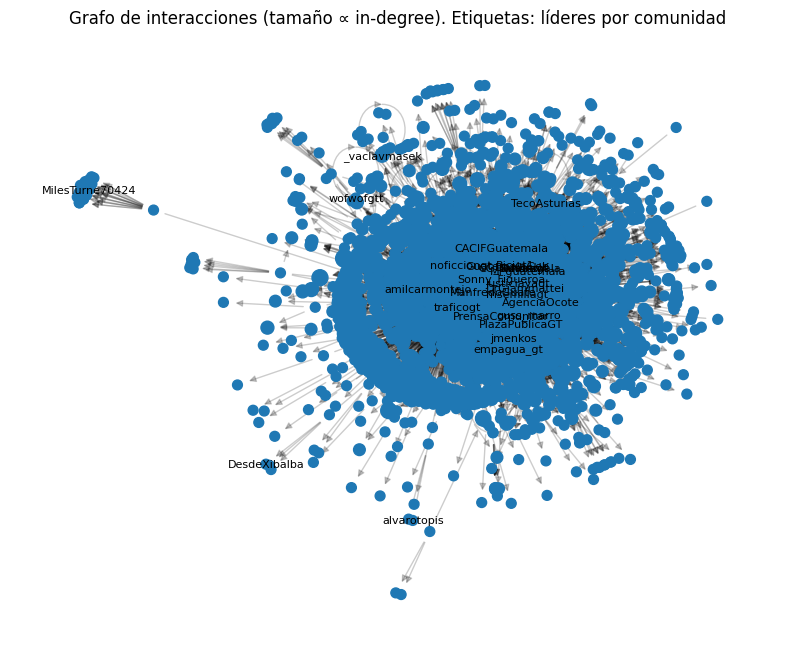

In [3]:

import math
import json
from pathlib import Path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def load_jsonl(file_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "utf-16", "latin1"]
    for enc in encodings_to_try:
        try:
            records = []
            with open(file_path, encoding=enc) as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
            return pd.DataFrame(records)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No pude decodificar {file_path}")

def build_graph_from_df(df: pd.DataFrame) -> nx.DiGraph:
    G = nx.DiGraph()
    for _, row in df.iterrows():
        try:
            user = row["user"]["username"]
        except Exception:
            continue
        # menciones
        musers = row.get("mentionedUsers")
        if isinstance(musers, list):
            for mention in musers:
                target = mention.get("username")
                if target:
                    G.add_edge(user, target, interaction="mention")
        # retweets
        rt = row.get("retweetedTweet")
        if isinstance(rt, dict):
            target = rt.get("user", {}).get("username")
            if target:
                G.add_edge(user, target, interaction="retweet")
        # replies
        reply_to = row.get("inReplyToUser")
        if isinstance(reply_to, dict):
            target = reply_to.get("username")
            if target:
                G.add_edge(user, target, interaction="reply")
    return G

globals_dict = globals()
traficogt_df = globals_dict.get("traficogt_df")
G_traficogt = globals_dict.get("G_traficogt")

if traficogt_df is None or not isinstance(traficogt_df, pd.DataFrame):
    data_path = Path("data") / "traficogt.txt"   # <-- ajusta si tu ruta es distinta
    traficogt_df = load_jsonl(data_path)

if G_traficogt is None or not isinstance(G_traficogt, nx.DiGraph):
    G_traficogt = build_graph_from_df(traficogt_df)

G_u = G_traficogt.to_undirected()
assert G_u.number_of_nodes() > 0 and G_u.number_of_edges() > 0, "Grafo vacío."

partition = None
modularity = None

try:
    import community as community_louvain
    partition = community_louvain.best_partition(G_u, random_state=42)
    modularity = community_louvain.modularity(partition, G_u)
    method_used = "Louvain (python-louvain)"
except Exception:
    from networkx.algorithms.community import greedy_modularity_communities
    from networkx.algorithms.community.quality import modularity as nx_modularity
    comms = list(greedy_modularity_communities(G_u))
    partition = {}
    for cid, nodes in enumerate(comms):
        for n in nodes:
            partition[n] = cid
    modularity = nx_modularity(G_u, comms)
    method_used = "Greedy Modularity (NetworkX)"

nx.set_node_attributes(G_traficogt, partition, "community")

from collections import defaultdict

comm2nodes = defaultdict(list)
for n, c in partition.items():
    comm2nodes[c].append(n)

rows = []
for cid, nodes in comm2nodes.items():
    n = len(nodes)
    if n <= 1:
        m_in = 0
        density_in = 0.0
    else:
        sub_nodes = set(nodes)
        m_in = sum(1 for u, v in G_traficogt.edges() if u in sub_nodes and v in sub_nodes)
        density_in = m_in / (n * (n - 1))  # densidad dirigida
    rows.append({"community": cid, "size": n, "edges_internal": m_in, "density_internal": density_in})

comm_df = pd.DataFrame(rows).sort_values(["size", "density_internal"], ascending=[False, False]).reset_index(drop=True)

in_deg = dict(G_traficogt.in_degree())
N = G_traficogt.number_of_nodes()
if N > 1000:
    btw = nx.betweenness_centrality(G_traficogt, k=min(200, N), normalized=True, seed=42)
else:
    btw = nx.betweenness_centrality(G_traficogt, normalized=True)

def top_k_in_dict(d, keys, k=5):
    items = [(node, d.get(node, 0.0)) for node in keys]
    items.sort(key=lambda x: x[1], reverse=True)
    return [f"{n} ({v:.3f})" for n, v in items[:k]]

leaders_rows = []
for cid, nodes in comm2nodes.items():
    leaders_rows.append({
        "community": cid,
        "top_in_degree": top_k_in_dict(in_deg, nodes, k=5),
        "top_betweenness": top_k_in_dict(btw, nodes, k=5),
    })
leaders_df = pd.DataFrame(leaders_rows).sort_values("community").reset_index(drop=True)

print(f"Método de comunidades: {method_used}")
print(f"Comunidades detectadas: {len(comm2nodes)} | Modularidad: {modularity:.4f}")
display(comm_df.head(10))
display(leaders_df.head(10))

if nx.is_weakly_connected(G_traficogt):
    G_vis = G_traficogt.copy()
else:
    largest_cc = max(nx.weakly_connected_components(G_traficogt), key=len)
    G_vis = G_traficogt.subgraph(largest_cc).copy()

sizes = []
for n in G_vis.nodes():
    deg = max(in_deg.get(n, 0), 1)
    sizes.append(50 * math.sqrt(deg))

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_vis.to_undirected(), seed=42)
nx.draw_networkx_edges(G_vis, pos, alpha=0.2)
nx.draw_networkx_nodes(G_vis, pos, node_size=sizes)

labels = {}
for cid, nodes in comm2nodes.items():
    vis_nodes = [n for n in nodes if n in G_vis]
    if not vis_nodes:
        continue
    top = top_k_in_dict(in_deg, vis_nodes, k=1)
    if top:
        name_only = top[0].split(" (")[0]
        labels[name_only] = name_only

nx.draw_networkx_labels(G_vis, pos, labels={n: n for n in labels if n in G_vis.nodes()}, font_size=8)
plt.title("Grafo de interacciones (tamaño ∝ in-degree). Etiquetas: líderes por comunidad")
plt.axis("off")
plt.show()


### Análisis de Comunidades

#### 1. Resumen global

- **Método:** Louvain (`python-louvain`)
- **Comunidades detectadas:** 20
- **Modularidad:** ≈ 0.47  
  Valor intermedio que indica agrupaciones claras pero con bastante interconexión (no son bloques aislados).

> La red de @traficogt presenta clústeres reconocibles (grupos de usuarios que interactúan más entre ellos), pero también existen puentes que mantienen cohesión entre comunidades.

#### 2. Principales comunidades

De acuerdo con la tabla de métricas (`comm_df`):

| Comunidad | Tamaño | Densidad interna | Líderes (in-degree) | Temática principal |
|-----------|--------|------------------|---------------------|-------------------|
| **6**     | 768    | 0.0019           | @traficogt, @BArevalodeLeon | Noticias de tráfico, política, figuras relevantes |
| **0**     | 201    | 0.0085           | @DrGiammattei, @MPguatemala | Mensajes institucionales y políticos |
| **3**     | 185    | 0.0102           | @amilcarmontejo, @muniguate | Tránsito urbano, información vial |

- **Comunidad 6:** Núcleo central del dataset.  
  - Rol: Hub principal, casi todos los usuarios orbitan alrededor de esta comunidad.
- **Comunidad 0:** Comunidad política/gubernamental.  
  - Rol: Agrupa usuarios vinculados a instituciones estatales y quienes interactúan con ellas.
- **Comunidad 3:** Comunidad centrada en movilidad y transporte en Ciudad de Guatemala.  
  - Rol: Conecta temas municipales y de tráfico con la discusión más amplia.

#### 3. Métricas adicionales

- **Tamaño de comunidades:**  
  Las comunidades varían desde 5 hasta 768 nodos.
- **Densidad interna:**  
  Va de 0.0019 (comunidad central) hasta 0.3 (comunidades pequeñas y densas).
- **Líderes por comunidad:**  
  Identificados por mayor in-degree y betweenness (ver tabla `leaders_df`).

#### 4. Interpretación

- Los líderes de cada comunidad actúan como nodos de referencia y puentes de información.
- La modularidad sugiere que, aunque hay agrupaciones claras, la red mantiene conectividad global.
- Las comunidades reflejan tanto agrupaciones temáticas (tráfico, política, medios) como roles funcionales (hubs, amplificadores, reporteros ciudadanos).


## 7. Centralidad de la red

**Objetivo.** Identificar a los usuarios más influyentes en la red a partir de diferentes medidas de **centralidad**.  

### Centralidades a calcular:
- **Degree centrality** (in/out-degree): mide popularidad (usuarios mencionados o que mencionan más).
- **Closeness centrality:** usuarios que pueden alcanzar rápidamente a los demás en la red.
- **Betweenness centrality:** usuarios que actúan como puentes entre comunidades.
- **Eigenvector centrality:** mide la influencia considerando conexiones con otros influyentes.
- **PageRank:** inspirado en Google, identifica nodos relevantes según el flujo de interacciones.

### Preguntas guía:
1. ¿Coinciden los usuarios más influyentes en todas las métricas?
2. ¿Existen usuarios “puente” que no son los más mencionados pero sí conectan comunidades?
3. ¿Cómo se diferencian líderes de opinión (alta betweenness) de hubs de tráfico (alto in-degree)?


In [4]:
import networkx as nx
import pandas as pd


print("Nodos:", G_traficogt.number_of_nodes(), " | Aristas:", G_traficogt.number_of_edges())

# --- 7.1 Centralidades ---
deg_in = dict(G_traficogt.in_degree())
deg_out = dict(G_traficogt.out_degree())
closeness = nx.closeness_centrality(G_traficogt)
betweenness = nx.betweenness_centrality(G_traficogt, normalized=True)
try:
    eigenvector = nx.eigenvector_centrality(G_traficogt, max_iter=500)
except nx.PowerIterationFailedConvergence:
    eigenvector = {n: 0 for n in G_traficogt.nodes()}
pagerank = nx.pagerank(G_traficogt)

# --- 7.2 DataFrame comparativo ---
def top_k(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

df_centralities = pd.DataFrame({
    "in_degree": pd.Series({n: v for n, v in deg_in.items()}),
    "out_degree": pd.Series({n: v for n, v in deg_out.items()}),
    "closeness": pd.Series(closeness),
    "betweenness": pd.Series(betweenness),
    "eigenvector": pd.Series(eigenvector),
    "pagerank": pd.Series(pagerank),
})

ranked = df_centralities.rank(ascending=False, method="min")
df_ranking = ranked.sort_values("in_degree").head(15)

display(df_centralities.head())
display(df_ranking)

# --- 7.3 Mostrar top 10 por cada métrica ---
print("\n=== Top 10 por in-degree ===")
print(top_k(deg_in, 10))
print("\n=== Top 10 por out-degree ===")
print(top_k(deg_out, 10))
print("\n=== Top 10 por closeness ===")
print(top_k(closeness, 10))
print("\n=== Top 10 por betweenness ===")
print(top_k(betweenness, 10))
print("\n=== Top 10 por eigenvector ===")
print(top_k(eigenvector, 10))
print("\n=== Top 10 por PageRank ===")
print(top_k(pagerank, 10))


Nodos: 2720  | Aristas: 7383


,in_degree,out_degree,closeness,betweenness,eigenvector,pagerank
monymmorales,21,1,0.007483,0.000001,1.144883e-08,0.000899
CC_Guatemala,79,0,0.254731,0.000000,1.850847e-01,0.013264
animaldgalaccia,0,6,0.000000,0.000000,1.085103e-14,0.000169
PNCdeGuatemala,35,0,0.042506,0.000000,4.844528e-05,0.001599
mingobguate,23,0,0.350234,0.000000,1.043799e-01,0.003396


,in_degree,out_degree,closeness,betweenness,eigenvector,pagerank
traficogt,1.0,4.0,1.0,1.0,3.0,1.0
BArevalodeLeon,2.0,1978.0,2.0,197.0,2.0,2.0
DrGiammattei,3.0,1486.0,3.0,60.0,5.0,5.0
PrensaComunitar,4.0,123.0,77.0,16.0,129.0,10.0
mmendoza_GT,5.0,295.0,5.0,6.0,16.0,8.0
MPguatemala,6.0,926.0,4.0,20.0,1.0,3.0
lahoragt,7.0,571.0,6.0,17.0,7.0,6.0
amilcarmontejo,8.0,926.0,80.0,40.0,194.0,15.0
CC_Guatemala,9.0,1978.0,47.0,197.0,4.0,4.0
muniguate,10.0,1978.0,81.0,197.0,81.0,56.0



=== Top 10 por in-degree ===
[('traficogt', 1892), ('BArevalodeLeon', 327), ('DrGiammattei', 132), ('PrensaComunitar', 121), ('mmendoza_GT', 109), ('MPguatemala', 102), ('lahoragt', 91), ('amilcarmontejo', 90), ('CC_Guatemala', 79), ('muniguate', 65)]

=== Top 10 por out-degree ===
[('mildred_gaitan', 111), ('batallonjalapa', 109), ('Chofito63569841', 58), ('traficogt', 46), ('CubReserva', 45), ('giovanottigt', 41), ('Erwin15', 37), ('hellboy17oc', 33), ('MariaCdeLeon1', 33), ('Erosan3Edsa', 32)]

=== Top 10 por closeness ===
[('traficogt', 0.6954762780433983), ('BArevalodeLeon', 0.3848046635421788), ('DrGiammattei', 0.3623340472636278), ('MPguatemala', 0.36150579752949386), ('mmendoza_GT', 0.3584250796903268), ('lahoragt', 0.35676630867733444), ('msemillagt', 0.3539784736592564), ('CongresoGuate', 0.35349061841530544), ('EmisorasUnidas', 0.3528591748383752), ('JLFont001', 0.35267531800654317)]

=== Top 10 por betweenness ===
[('traficogt', 0.01850274321192733), ('ServoVeritatis', 0.0

### Análisis de Centralidades (Punto 7)

#### 1. Influencia por **In-Degree**
**Top cuentas más mencionadas/retuiteadas:**  
`@traficogt`, `@BArevalodeLeon`, `@DrGiammattei`, `@PrensaComunitar`, `@MPguatemala`

> *Interpretación:* Reflejan a los usuarios más visibles/referenciados, es decir, aquellos de los que más se habla.

---

#### 2. Actividad por **Out-Degree**
**Top cuentas que más mencionan a otros:**  
`@mildred_gaitan`, `@batallonjalapa`, `@Chofito63569841`, además de `@traficogt`

> *Interpretación:* Son cuentas altamente activas en generar interacciones, aunque no siempre son las más influyentes.

---

#### 3. **Closeness Centrality**
**Top:**  
`@traficogt`, `@BArevalodeLeon`, `@DrGiammattei`, `@MPguatemala`, `@lahoragt`

> *Interpretación:* Estos usuarios pueden alcanzar rápidamente al resto de la red → ideales para difusión de mensajes.

---

#### 4. **Betweenness Centrality**
**Top:**  
`@traficogt` (destacado), seguido por `@ServoVeritatis`, `@madridistaguate`, `@JLFont001`, `@QuorumGT`

> *Interpretación:* Aquí aparecen puentes que no necesariamente son los más mencionados, pero sí claves en conectar comunidades distintas.

---

#### 5. **Eigenvector Centrality**
**Top:**  
`@MPguatemala`, `@BArevalodeLeon`, `@traficogt`, `@CC_Guatemala`, `@DrGiammattei`

> *Interpretación:* Mide influencia considerando también conexiones con otros influyentes → vemos a instituciones y políticos.

---

#### 6. **PageRank**
**Top:**  
`@traficogt`, `@BArevalodeLeon`, `@MPguatemala`, `@CC_Guatemala`, `@DrGiammattei`

> *Interpretación:* Confirma el rol jerárquico de estos actores en el flujo de información.

---

#### **Insights principales**

- `@traficogt` domina en todas las métricas → es el **hub absoluto** de la red.
- Políticos e instituciones oficiales (`@BArevalodeLeon`, `@DrGiammattei`, `@MPguatemala`, `@CC_Guatemala`) aparecen como líderes tanto por menciones como por influencia estructural.
- Medios y periodistas (`@PrensaComunitar`, `@lahoragt`, `@mmendoza_GT`) destacan como actores secundarios influyentes.
- Usuarios puente (ej. `@ServoVeritatis`, `@JLFont001`) no son tan mencionados pero sí cruciales en la conectividad → pueden ser “brokers de información”.
- El contraste entre **out-degree** (usuarios muy activos en generar interacciones) y **in-degree** (usuarios de los que se habla) muestra asimetría: pocos líderes concentran la atención, muchos periféricos generan ruido.

## 8. Robustez de la red ante fallas y ataques

**Metodología:**
- Calculamos un ranking de nodos por **centralidad** (por defecto, PageRank).
- Removemos nodos en **K pasos** (0% → 20%) siguiendo dos estrategias:
  1) **Dirigida** (top por PageRank): simula un ataque a los más influyentes.
  2) **Aleatoria**: simula fallas al azar (con T repeticiones para promedio).
- En cada paso medimos:
  - `giant_ratio`: tamaño relativo del **componente más grande** (no dirigido).
  - `n_components`: número de componentes (no dirigido).
  - `avg_path_len`: longitud de camino promedio en el componente gigante (no dirigido).
  - `clustering`: coeficiente de agrupamiento promedio (no dirigido).
  - `density`: densidad (no dirigido).
  - `diameter`: diámetro del componente gigante (si es alcanzable).

**Interpretación esperada:**
- Una red **robusta** mantiene alto `giant_ratio` bajo eliminaciones aleatorias.
- Una red **frágil** ante ataques verá caer rápidamente `giant_ratio` cuando removemos nodos de mayor centralidad.


In [5]:
import random
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

assert isinstance(G_traficogt, nx.DiGraph) and G_traficogt.number_of_nodes() > 0

def largest_undirected_subgraph(G: nx.Graph) -> nx.Graph:
    """Devuelve el subgrafo no dirigido del componente más grande (por nodos)."""
    Gu = G.to_undirected()
    if Gu.number_of_nodes() == 0:
        return Gu
    comp = max(nx.connected_components(Gu), key=len)
    return Gu.subgraph(comp).copy()

def safe_avg_shortest_path_length(Gu: nx.Graph, max_nodes_for_exact=5000):
    """
    Longitud de camino promedio en el componente gigante.
    Si es muy grande, hace una aproximación por muestreo.
    """
    if Gu.number_of_nodes() == 0:
        return np.nan
    n = Gu.number_of_nodes()
    if nx.is_connected(Gu) and n <= max_nodes_for_exact:
        try:
            return nx.average_shortest_path_length(Gu)
        except Exception:
            return np.nan
    nodes = list(Gu.nodes())
    samples = min(2000, n * 5)
    if samples == 0:
        return np.nan
    total = 0.0
    cnt = 0
    for _ in range(samples):
        a, b = random.sample(nodes, 2)
        try:
            d = nx.shortest_path_length(Gu, a, b)
            total += d
            cnt += 1
        except nx.NetworkXNoPath:
            continue
    return (total / cnt) if cnt > 0 else np.nan

def safe_diameter(Gu: nx.Graph, max_nodes_for_exact=1500):
    """Diámetro del componente gigante si es manejable; si no, devuelve NaN."""
    if Gu.number_of_nodes() == 0 or not nx.is_connected(Gu):
        return np.nan
    n = Gu.number_of_nodes()
    if n <= max_nodes_for_exact:
        try:
            return nx.diameter(Gu)
        except Exception:
            return np.nan
    return np.nan

def snapshot_metrics(G: nx.DiGraph):
    """Calcula métricas clave sobre el grafo actual."""
    Gu = G.to_undirected()
    n_nodes = Gu.number_of_nodes()
    n_edges = Gu.number_of_edges()
    if n_nodes == 0:
        return dict(
            n_nodes=0, n_edges=0, n_components=0, giant_ratio=0.0,
            clustering=np.nan, density=np.nan, avg_path_len=np.nan, diameter=np.nan
        )

    comps = list(nx.connected_components(Gu))
    n_components = len(comps)
    giant_size = len(max(comps, key=len))
    giant_ratio = giant_size / n_nodes

    Gg = Gu.subgraph(max(comps, key=len)).copy()
    clustering = nx.average_clustering(Gu)
    density = nx.density(Gu)
    avg_path_len = safe_avg_shortest_path_length(Gg)
    diameter = safe_diameter(Gg)

    return dict(
        n_nodes=n_nodes,
        n_edges=n_edges,
        n_components=n_components,
        giant_ratio=giant_ratio,
        clustering=clustering,
        density=density,
        avg_path_len=avg_path_len,
        diameter=diameter
    )

def rank_nodes_for_attack(G: nx.DiGraph, strategy="pagerank"):
    """Devuelve una lista de nodos ordenados de más a menos 'críticos' según la estrategia."""
    if strategy == "pagerank":
        pr = nx.pagerank(G)
        return sorted(pr, key=pr.get, reverse=True)
    elif strategy == "in_degree":
        return [n for n, _ in sorted(G.in_degree(), key=lambda x: x[1], reverse=True)]
    elif strategy == "betweenness":
        k = min(800, G.number_of_nodes())
        btw = nx.betweenness_centrality(G, k=k, normalized=True, seed=42) if G.number_of_nodes() > 1500 \
              else nx.betweenness_centrality(G, normalized=True)
        return sorted(btw, key=btw.get, reverse=True)
    else:
        raise ValueError("Estrategia no soportada. Usa: 'pagerank' | 'in_degree' | 'betweenness'")

def simulate_targeted_failure(G: nx.DiGraph, fractions, strategy="pagerank"):
    """Elimina fracciones crecientes de nodos según ranking y recolecta métricas."""
    nodes_order = rank_nodes_for_attack(G, strategy=strategy)
    results = []
    for f in fractions:
        k = int(round(f * G.number_of_nodes()))
        removed = set(nodes_order[:k])
        H = G.copy()
        H.remove_nodes_from(removed)
        m = snapshot_metrics(H)
        m.update(dict(frac_removed=f, removed=k, mode=f"targeted_{strategy}"))
        results.append(m)
    return results

def simulate_random_failure(G: nx.DiGraph, fractions, trials=5, seed=42):
    """Elimina nodos al azar; promedia métricas sobre T repeticiones."""
    rng = random.Random(seed)
    results = []
    nodes_all = list(G.nodes())
    for f in fractions:
        k = int(round(f * G.number_of_nodes()))
        trial_metrics = []
        for t in range(trials):
            removed = set(rng.sample(nodes_all, k))
            H = G.copy()
            H.remove_nodes_from(removed)
            trial_metrics.append(snapshot_metrics(H))
        avg = {k: np.nanmean([m[k] for m in trial_metrics]) for k in trial_metrics[0].keys()}
        avg.update(dict(frac_removed=f, removed=k, mode=f"random_T{trials}"))
        results.append(avg)
    return results


C:\Users\diego\AppData\Local\Temp\ipykernel_19700\1227106544.py:134: RuntimeWarning: Mean of empty slice
  avg = {k: np.nanmean([m[k] for m in trial_metrics]) for k in trial_metrics[0].keys()}


Resultados guardados en: robustness_results.csv


,n_nodes,n_edges,n_components,giant_ratio,clustering,density,avg_path_len,diameter,frac_removed,mode,removed
0,2720.0,7330.000,1.000,1.000000,0.233942,0.001982,2.572457,NaN,0.00,baseline,0
12,2720.0,7330.000,1.000,1.000000,0.233942,0.001982,2.572457,NaN,0.00,random_T8,0
13,2666.0,6873.750,65.250,0.972993,0.217024,0.001935,2.746960,NaN,0.02,random_T8,54
14,2611.0,6863.000,20.250,0.992627,0.231717,0.002014,2.563835,NaN,0.04,random_T8,109
15,2557.0,6576.375,25.625,0.990370,0.227230,0.002012,2.558234,NaN,0.06,random_T8,163
16,2502.0,6317.500,34.125,0.986711,0.227371,0.002019,2.551316,NaN,0.08,random_T8,218
17,2448.0,5975.375,96.500,0.957823,0.214010,0.001995,2.734438,NaN,0.10,random_T8,272
18,2394.0,5666.250,95.125,0.957080,0.206091,0.001978,2.722544,NaN,0.12,random_T8,326


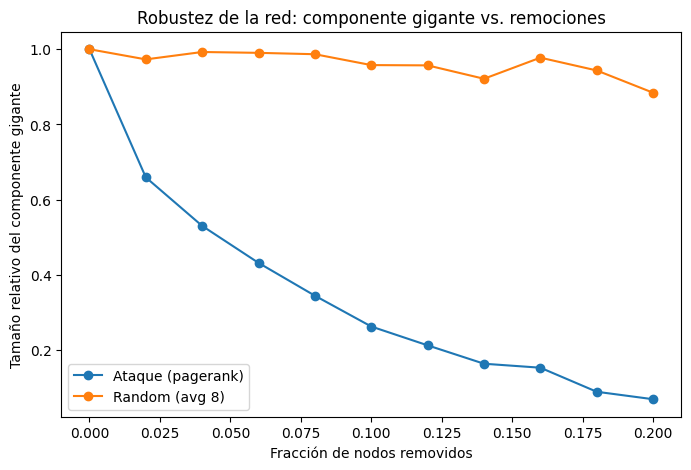

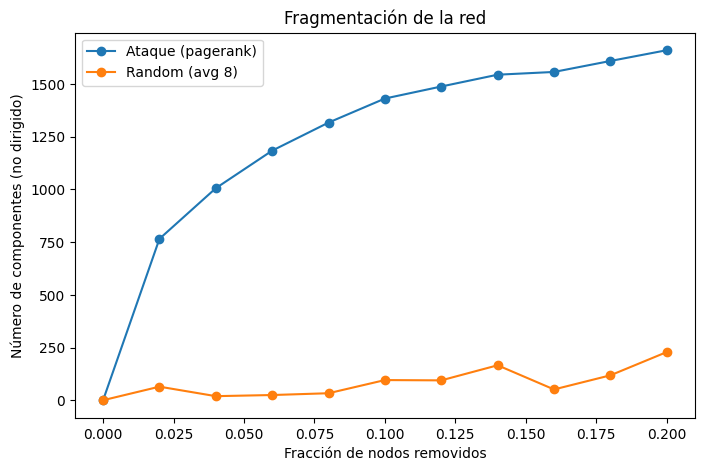

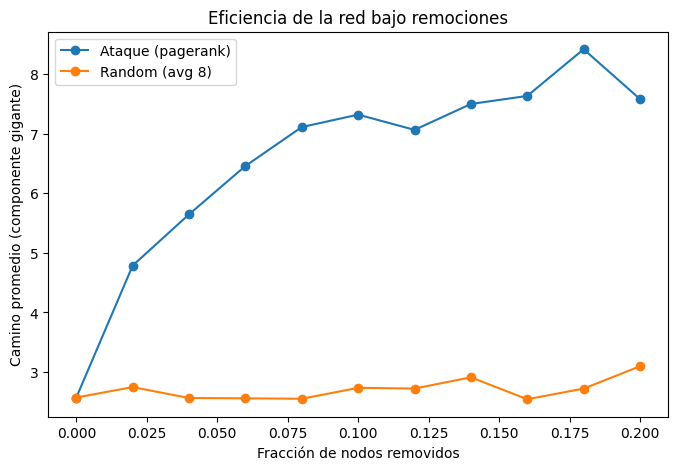

In [6]:
# --- Parámetros del experimento ---
fractions = np.linspace(0, 0.20, 11)  # 0% a 20% en 11 pasos
attack_metric = "pagerank"             # opciones: 'pagerank' | 'in_degree' | 'betweenness'
random_trials = 8

# --- Correr simulaciones ---
base_metrics = snapshot_metrics(G_traficogt)
res_attack = simulate_targeted_failure(G_traficogt, fractions, strategy=attack_metric)
res_random = simulate_random_failure(G_traficogt, fractions, trials=random_trials)

df_attack = pd.DataFrame(res_attack)
df_random = pd.DataFrame(res_random)
df_base = pd.DataFrame([base_metrics]).assign(frac_removed=0.0, mode="baseline", removed=0)

df_robustness = pd.concat([df_base, df_attack, df_random], ignore_index=True)
df_robustness.sort_values(["mode", "frac_removed"], inplace=True)

# Guardar resultados
out_csv = "robustness_results.csv"
df_robustness.to_csv(out_csv, index=False)
print(f"Resultados guardados en: {out_csv}")
display(df_robustness.head(8))

# --- Gráfico 1: Tamaño relativo del componente gigante ---
plt.figure(figsize=(8,5))
subset_a = df_robustness[df_robustness["mode"].str.startswith("targeted")]
subset_r = df_robustness[df_robustness["mode"].str.startswith("random")]
plt.plot(subset_a["frac_removed"], subset_a["giant_ratio"], marker="o", label=f"Ataque ({attack_metric})")
plt.plot(subset_r["frac_removed"], subset_r["giant_ratio"], marker="o", label=f"Random (avg {random_trials})")
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Tamaño relativo del componente gigante")
plt.title("Robustez de la red: componente gigante vs. remociones")
plt.legend()
plt.show()

# --- Gráfico 2: Número de componentes ---
plt.figure(figsize=(8,5))
plt.plot(subset_a["frac_removed"], subset_a["n_components"], marker="o", label=f"Ataque ({attack_metric})")
plt.plot(subset_r["frac_removed"], subset_r["n_components"], marker="o", label=f"Random (avg {random_trials})")
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Número de componentes (no dirigido)")
plt.title("Fragmentación de la red")
plt.legend()
plt.show()

# --- Gráfico 3: Longitud de camino promedio (en el gigante) ---
plt.figure(figsize=(8,5))
plt.plot(subset_a["frac_removed"], subset_a["avg_path_len"], marker="o", label=f"Ataque ({attack_metric})")
plt.plot(subset_r["frac_removed"], subset_r["avg_path_len"], marker="o", label=f"Random (avg {random_trials})")
plt.xlabel("Fracción de nodos removidos")
plt.ylabel("Camino promedio (componente gigante)")
plt.title("Eficiencia de la red bajo remociones")
plt.legend()
plt.show()


## 8. Análisis de robustez de la red

### 1. Ataques dirigidos vs fallas aleatorias
- **Fallas aleatorias (línea naranja):**  
  La red mantiene estable el tamaño del componente gigante (cerca de 100%) incluso eliminando hasta 20% de los nodos.  
  Esto indica que la red es **robusta ante fallas aleatorias**, característica típica de redes **scale-free** donde la mayoría de nodos son periféricos y no afectan la conectividad global.

- **Ataques dirigidos (línea azul, PageRank):**  
  Al eliminar de forma intencional los nodos más influyentes, la red colapsa rápidamente.  
  Con solo remover ~5% de los nodos principales, el componente gigante cae por debajo del 50%.  
  Esto evidencia que la red es **altamente vulnerable a ataques dirigidos contra hubs** (ej. `@traficogt`, `@BArevalodeLeon`, `@MPguatemala`).

---

### 2. Fragmentación
- En ataques dirigidos, el número de componentes sube drásticamente (de 1 a más de 1500 con 20% removido).  
- En fallas aleatorias, el aumento de componentes es mínimo y gradual.  
- Esto confirma que la red **se fragmenta en múltiples islas** solo cuando se atacan los hubs.

---

### 3. Eficiencia de la red
- **Camino promedio:**  
  Bajo ataques dirigidos, la longitud de camino promedio sube rápidamente (de ~2.6 a más de 8).  
  Bajo fallas aleatorias, se mantiene prácticamente estable.  
- Esto significa que la red se vuelve mucho menos eficiente en transmitir información cuando se pierde a los nodos estratégicos.

---

### 4. Conclusión
- La red de `traficogt` presenta el patrón clásico de las redes sociales online:  
  - **Muy robusta** a fallas aleatorias (resiliente).  
  - **Muy frágil** a ataques dirigidos contra los hubs principales.  
- Esto se debe a su estructura **libre de escala** (*scale-free*), donde pocos nodos concentran la mayoría de conexiones.  
- En términos prácticos, los usuarios líderes (como `@traficogt`, `@BArevalodeLeon`, `@MPguatemala`) sostienen la conectividad global: eliminarlos fragmenta la red y reduce su eficiencia dramáticamente.
